# VAE Exercise


 ### GENERAL INFORMATION
 * Deep Learning – Winter term 2020/21
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
 * Due date: **Tue, Jan 26, 14:00**

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train+test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space


## Setup and requirements

### Imports

In [1]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
Python 3.9.1
1.7.1+cu110


### Basic setup

Define various global parameters used throughout the notebook!

In [2]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 432x288 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [3]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')


Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook!

In [4]:
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = datasets.FashionMNIST(data_dir, train=False, transform=transforms.ToTensor())

For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook!

Define data loaders for the training and test sets which return batches of samples.

In [5]:
# Define the data loaders
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Save data set sizes for later
train_size    = len(train_dataset)
test_size     = len(test_dataset)
train_batches = len(train_loader)
test_batches  = len(test_loader)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

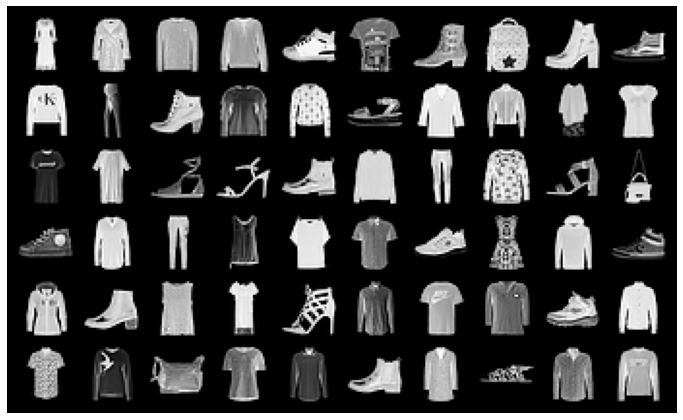

In [6]:
images_columns = 10
images_rows    = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)


## Implement a convolutional Variational Autoencoder (VAE)

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).


![alt text](https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class template and loss function and implement the missing parts according to the following specification: 

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 
**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each 
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

In [7]:
class VAE(nn.Module):

    def __init__(self, image_size=28, latent_dims=10, capacity=32):
        super(VAE, self).__init__()

        self.latent_dims  = latent_dims
        self.image_size   = image_size
        self.capacity     = capacity

        # Encoder
        self.encoder = nn.Sequential(
            # TODO
            nn.Conv2d(1, self.capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.capacity, 2*self.capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Sampling
        self.fc_mu      = nn.Linear(2*self.capacity*7*7, self.latent_dims) # TODO
        self.fc_logvar  = nn.Linear(2*self.capacity*7*7, self.latent_dims) # TODO
        self.fc_z       = nn.Linear(self.latent_dims, 2*self.capacity*7*7) # TODO

        # Decoder
        self.decoder = nn.Sequential(
            # TODO
            nn.Unflatten(1, (2*self.capacity, 7, 7)),
            nn.ConvTranspose2d(2*self.capacity, self.capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.capacity, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
  
    def encode(self, x):
        ''' Encoder: output is (mean, log(variance))'''
        # TODO
        out    = self.encoder(x)
        mu     = self.fc_mu(torch.flatten(out, start_dim=1))
        logvar = self.fc_logvar(torch.flatten(out, start_dim=1))
        return mu, logvar

    def sample(self, mu, logvar):
        ''' Sample from Gaussian with mean `mu` and SD `sqrt(exp(logvarz))`'''
        if self.training:
            # TODO: Reparameterization + sampling
            return mu + torch.sqrt(torch.exp(logvar)).cuda() * torch.normal(0, 1, size=(mu.shape[0], self.latent_dims)).cuda()
        else:
            # During testing we don't sample but take the mean
            return mu

    def decode(self, z):
        '''Decoder: produces reconstruction from sample of latent z'''
        # TODO
        x_hat = self.fc_z(z)
        x_hat = self.decoder(x_hat)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar



### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:** Make sure that you use sum instead of mean for calculating the MSE loss!

In [8]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    #mse_loss = torch.sum(torch.mean(torch.square(recon_x - x), (1, 2))) # TODO
    mse_loss = nn.MSELoss(reduction='sum')(recon_x, x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - torch.square(mu) - torch.exp(logvar), 1)) # TODO

    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [9]:
model = VAE(image_size, latent_space_dim, capacity) # TODO
optimizer = optim.Adam  # TODO

In [10]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot**


In [11]:
import Exercises5_utils

# Helper function that does the training, based on parameters
def doTraining(model, title, trainloader, testloader, device, epochs = 100, lr = 0.001, loss_function = nn.CrossEntropyLoss(), optimizer = optim.Adam):
  
    # Move the model to the device
    model.to(device)

    # Setup the optimizer
    params = list(model.parameters())
    optimizer = optimizer(params, lr)

    Exercises5_utils.printmd("###**" + title + "**")

    train_losses, test_losses, train_mse_losses, test_mse_losses, train_kld_losses, test_kld_losses = Exercises5_utils.run_training(model, optimizer, loss_function, device, epochs, trainloader, testloader)

    # Find and print out the best results
    best_loss_epoch, best_mse_loss_epoch, best_kld_loss_epoch = Exercises5_utils.printBestValues(test_losses, test_mse_losses, test_kld_losses)

    Exercises5_utils.plot("Total Loss vs epoch", "Loss", train_losses, test_losses, extra_pt = (best_loss_epoch, test_losses[best_loss_epoch]), extra_pt_label = "Epoch with lowest total validation loss")
    Exercises5_utils.plot("MSE Loss vs epoch", "Loss", train_mse_losses, test_mse_losses, extra_pt = (best_mse_loss_epoch, test_mse_losses[best_mse_loss_epoch]), extra_pt_label = "Epoch with lowest MSE validation loss")
    Exercises5_utils.plot("KLD Loss vs epoch", "Loss", train_kld_losses, test_kld_losses, extra_pt = (best_kld_loss_epoch, test_kld_losses[best_kld_loss_epoch]), extra_pt_label = "Epoch with lowest KLD validation loss")
    print("================================================================\n\n")


###**VAE Training for 5 epochs**

Finished training after 44 seconds.
Lowest total validation loss:     2832.2968398468406 (in epoch 4)
Lowest MSE validation loss:     1755.046694984919 (in epoch 5)
Lowest KLD validation loss:     1025.264477693582 (in epoch 4)


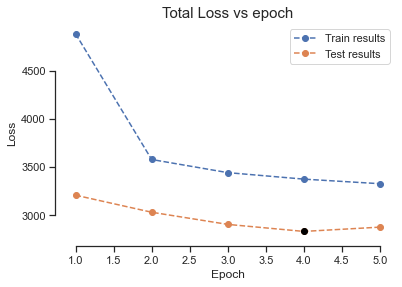

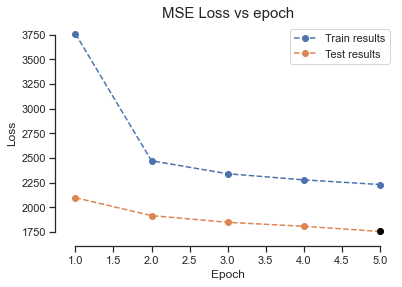

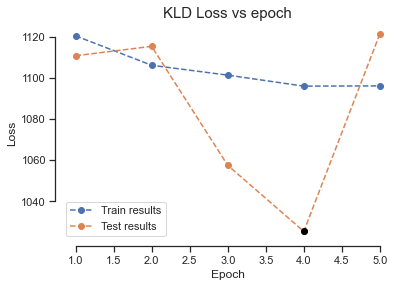

In [12]:
# TODO
doTraining(
    model = model,
    title = "VAE Training for 5 epochs",
    trainloader = train_loader,
    testloader = test_loader,
    device = device,
    epochs = epochs,
    lr = learning_rate,
    loss_function = vae_loss,
    optimizer = optimizer
)

### Visualization of random samples from the latent space

Here we create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

torch.Size([10, 1, 28, 28])


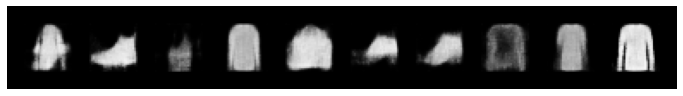

In [22]:
with torch.no_grad():
    # TODO
    noise = torch.normal(0, 1, size=(10, 10)).to(device)
    samples = model.decode(noise)
    print(samples.shape)

    samples = samples.cpu()
    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare to the original images!

Original images


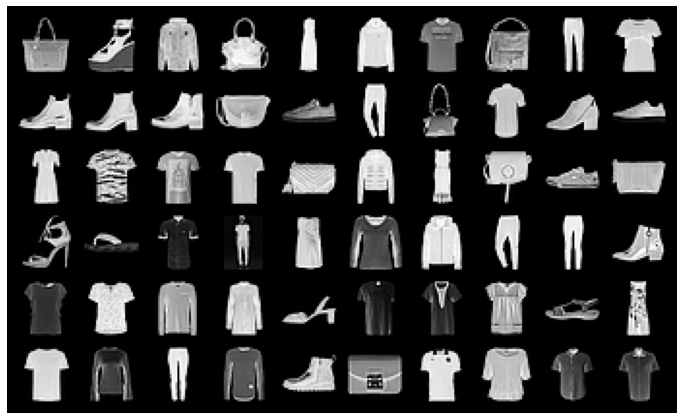




Reconstructed images


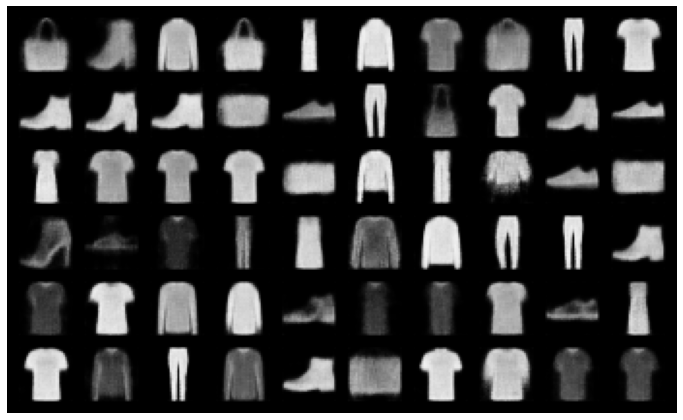

In [14]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

# Show original images
print("Original images")
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)
print("\n\n")

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    x_hat, mu, logvar = model(images.to(device))
    images_recon = x_hat.cpu()

    print("Reconstructed images")
    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)


### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set loss.

###**VAE Training for 5 epochs, latent dims: 2**

Finished training after 42 seconds.
Lowest total validation loss:     3754.226843725277 (in epoch 5)
Lowest MSE validation loss:     3190.8446238071106 (in epoch 5)
Lowest KLD validation loss:     533.9448654561103 (in epoch 1)


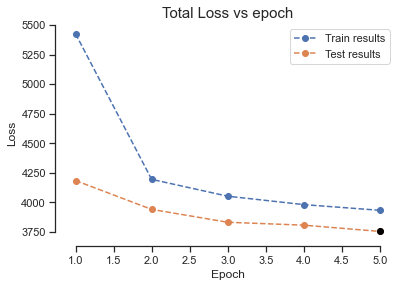

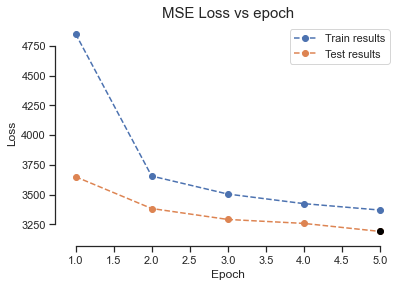

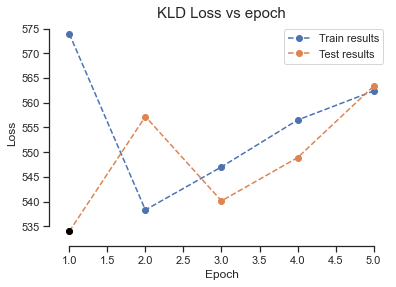

###**VAE Training for 5 epochs, latent dims: 4**

Finished training after 44 seconds.
Lowest total validation loss:     3051.8802018950255 (in epoch 4)
Lowest MSE validation loss:     2198.1293284742137 (in epoch 5)
Lowest KLD validation loss:     811.2921395603614 (in epoch 4)


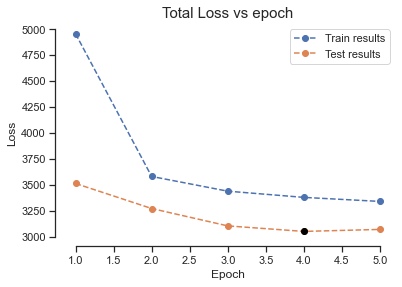

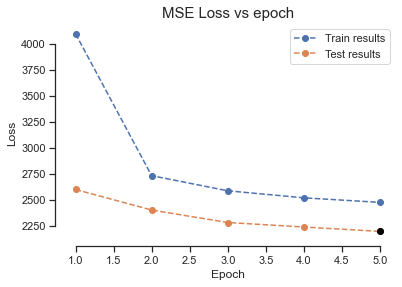

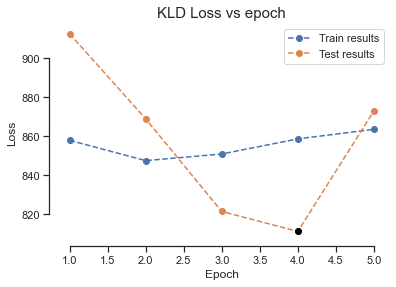

###**VAE Training for 5 epochs, latent dims: 8**

Finished training after 44 seconds.
Lowest total validation loss:     2869.4464439681815 (in epoch 5)
Lowest MSE validation loss:     1814.8055203594738 (in epoch 5)
Lowest KLD validation loss:     1015.092116150675 (in epoch 3)


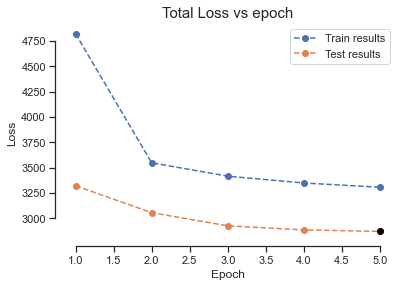

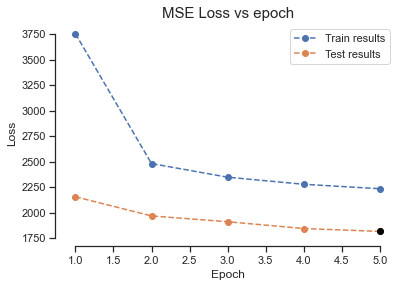

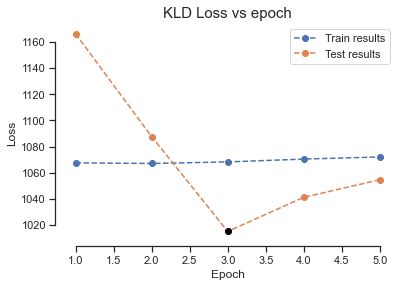

###**VAE Training for 5 epochs, latent dims: 16**

Finished training after 44 seconds.
Lowest total validation loss:     2838.2429767077483 (in epoch 5)
Lowest MSE validation loss:     1811.182821539384 (in epoch 5)
Lowest KLD validation loss:     1027.060157486155 (in epoch 5)


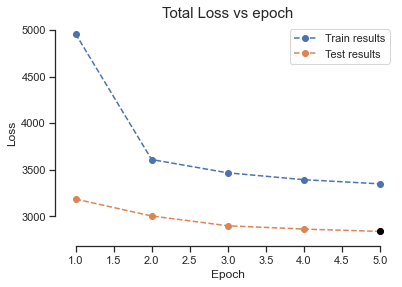

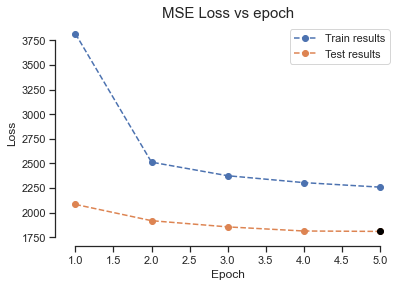

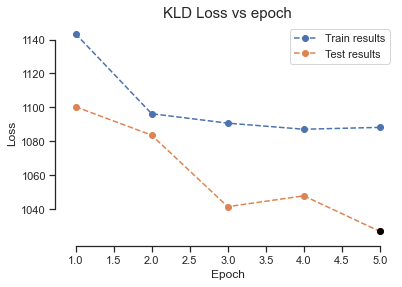

###**VAE Training for 5 epochs, latent dims: 32**

Finished training after 44 seconds.
Lowest total validation loss:     2819.115213128585 (in epoch 5)
Lowest MSE validation loss:     1787.7584313501286 (in epoch 5)
Lowest KLD validation loss:     1031.3567810058594 (in epoch 5)


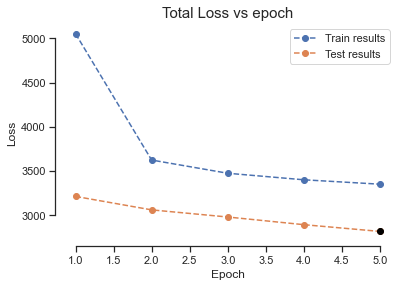

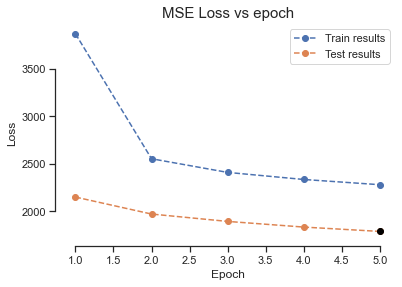

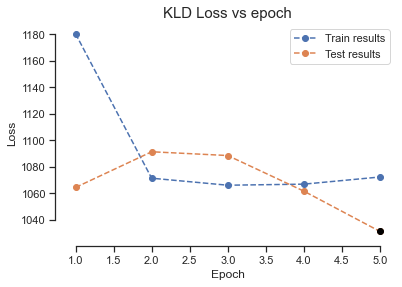

In [15]:
# TODO
for lat_dim in [2, 4, 8, 16, 32]:
    tmp_model = VAE(image_size, lat_dim, capacity) # TODO
    optimizer = optim.Adam  # TODO

    doTraining(
        model = tmp_model,
        title = "VAE Training for 5 epochs, latent dims: " + str(lat_dim),
        trainloader = train_loader,
        testloader = test_loader,
        device = device,
        epochs = epochs,
        lr = learning_rate,
        loss_function = vae_loss,
        optimizer = optimizer
    )

## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. 
[https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123550681.pdf]

Create a 10 x 10 matrix plot showing latent space travels by selecting vectors from latent space and using the decoder part of the VAE neural network to create images from them. 

**TODO**
- select two separate latent space dimensions of the vector, e.g. axi=1, axj=9
- create a vector with of size *latent_space_dim* containing zeros
- traverse the latent space dimensions from -3 to 3 in 10 steps, each time setting the value of the vector at axi and axj to the current traversed value
- use the decoder to create the corresponding image and plot it
- repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero.

An example is shown here: 

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)


Zero initialization


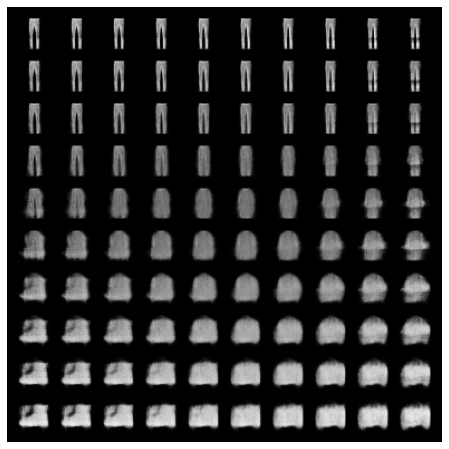



Random initialization


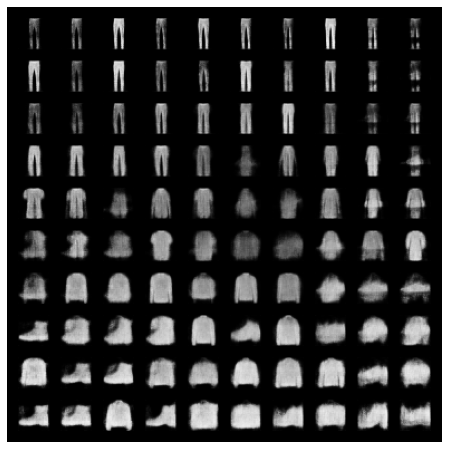

In [25]:
# TODO
images_columns = 10
images_rows    = 10

axi, axj     = 1, 7

space_vector = torch.zeros((1, 10), device=device)
result       = torch.zeros((100, 1, 28, 28), device=device)
i, j         = 0, 0


print("Zero initialization")
model.eval()
model.Training = False
with torch.no_grad():
    for x in np.arange(-3, 3, 0.6):
        for y in np.arange(-3, 3, 0.6):
            space_vector = torch.zeros((1, 10), device=device)
            space_vector[0, axi] = x
            space_vector[0, axj] = y

            result[i] = model.decode(space_vector)

            i += 1


result = result.cpu()
show_grid(result[0:(images_columns * images_rows)], images_columns, images_rows)

print("\n\nRandom initialization")

space_vector = torch.zeros((1, 10), device=device)
result       = torch.zeros((100, 1, 28, 28), device=device)
i, j         = 0, 0
with torch.no_grad():
    for x in np.arange(-3, 3, 0.6):
        for y in np.arange(-3, 3, 0.6):
            space_vector = (-2) * torch.rand((1, 10), device=device) + 1
            space_vector[0, axi] = x
            space_vector[0, axj] = y

            result[i] = model.decode(space_vector)

            i += 1


result = result.cpu()
show_grid(result[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels. 

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

#### Train 2d latent space model

###**2D VAE Training for 5 epochs**

Finished training after 45 seconds.
Lowest total validation loss:     2931.8711231086827 (in epoch 5)
Lowest MSE validation loss:     1882.7159371677833 (in epoch 5)
Lowest KLD validation loss:     970.7403943991359 (in epoch 1)


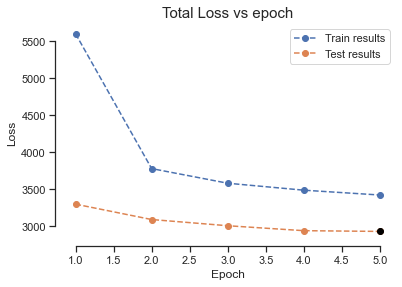

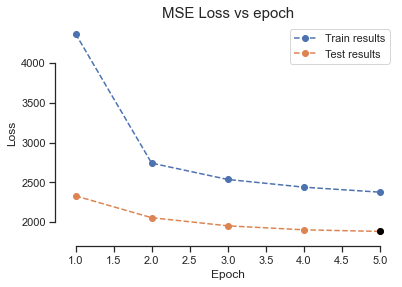

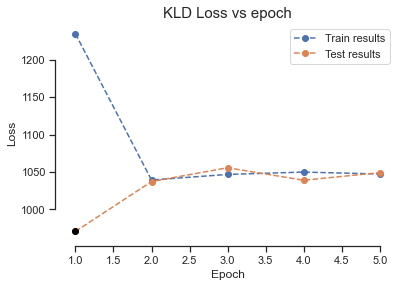

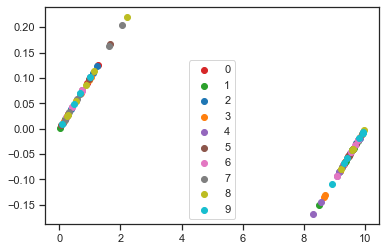

In [17]:
# TODO
model2d = VAE(image_size, latent_space_dim * latent_space_dim, capacity) # TODO
optimizer = optim.Adam

doTraining(
    model = model2d,
    title = "2D VAE Training for 5 epochs",
    trainloader = train_loader,
    testloader = test_loader,
    device = device,
    epochs = epochs,
    lr = learning_rate,
    loss_function = vae_loss,
    optimizer = optimizer
)

model.eval()
model.Training = False
result = [[], [], [], [], [], [], [], [], [], []]
color = ["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

with torch.no_grad():
    for batchx, batchy in train_loader:
        for x, y in zip(batchx, batchy):
            mu, logvar = model.encode(x[None, :, :, :].to(device))
            result[y] = mu

    for i in range(10):
        for val in result[i]:
            x, y = val % 10, val / 10
            x, y = x.cpu(), y.cpu()
            plt.scatter(x, y, c=color[i], label=str(i))

    plt.legend()
    plt.show()
        


#### Visualize classes

In [18]:
# TODO

## Appendix [OPTIONAL]

Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [19]:
transform = transforms.Compose([ 
#                transforms.Resize(image_size),
                transforms.ToTensor(),
#                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())